# Validate embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/21 11:02:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/21 11:02:51 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Fri Feb 21 11:02:57 AM EST 2025


In [4]:
# Path and dataset names
data_path = f"{root}/scratch/plantclef/data/parquet"

# Define the path to the train and test parquet files
train_path = f"{data_path}/train"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)

# Show the data
train_df.printSchema()
train_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+--------------------+--------------------+--------------------+------+----------+----------+--------------------+-------+-----------------+--------+------------------+------------------+---------------+--------------------+----------------+--------------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data| organ|species_id|    obs_id|             license|partner|           author|altitude|          latitude|         longitude|gbif_species_id|             species|           genus|        family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+------+----------+----------+--------------------+-------+-----------------+--------+------------------+------------------+---------------+--------------------+----------------+--------------+--------+-----------+--------------------+

### subset embedding data

In [14]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/"

# Define the path to the train and test parquet files
subset_train_path = f"{data_path}/embeddings/subset_top20_train_embeddings/data"

# Read the parquet files into a spark DataFrame
subset_df = spark.read.parquet(subset_train_path)

# Show the data
subset_df.printSchema()
subset_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+----------+--------------------+---------+
|          image_name|species_id|       cls_embedding|sample_id|
+--------------------+----------+--------------------+---------+
|a7d82ce1a990d21f3...|   1743246|[0.10556483, -0.0...|        0|
|3fa3f94a36e33331b...|   1394624|[0.17451216, 0.40...|        0|
|f4dedf4fadf6c67d1...|   1394624|[0.61694634, 0.40...|        0|
|5d0a8ae90e19c3c1d...|   1359162|[0.2670945, 0.218...|        0|
|b52775178eefe5558...|   1359162|[0.98361766, 0.75...|        0|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [ ]:
# Join with subset_df with train_df to get species names
joined_df = subset_df.join(train_df, "image_name", "inner").select(
    [
        subset_df["image_name"],
        train_df["species"],
        subset_df["species_id"],
        subset_df["cls_embedding"],
    ]
)
joined_df.show(n=5)

+--------------------+--------------------+----------+--------------------+
|          image_name|             species|species_id|       cls_embedding|
+--------------------+--------------------+----------+--------------------+
|010fb6728439fa33c...|    Arbutus unedo L.|   1358500|[0.5650823, 0.042...|
|0387667ac92605ae4...|   Lotus hirsutus L.|   1743246|[0.099583335, 0.5...|
|0530a9f8a05123e1a...|Lathyrus oleraceu...|   1741625|[-0.08563455, 0.3...|
|0534737bfc771ebac...|Calamagrostis are...|   1722433|[-0.0044867285, -...|
|068421adac2878598...|Oxalis dillenii J...|   1394359|[0.845592, -0.057...|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



In [16]:
# select 9 images for plotting
image_names = joined_df.select("image_name").limit(9).collect()
image_names = [row.image_name for row in image_names]

# filter the joined_df to only include the 9 images
filtered_df = joined_df.filter(joined_df.image_name.isin(image_names))
filtered_df.show(n=9)

+--------------------+-----------------+----------+--------------------+
|          image_name|          species|species_id|       cls_embedding|
+--------------------+-----------------+----------+--------------------+
|05c6a338d8524f506...|Ulmus minor Mill.|   1360607|[0.23002021, 0.44...|
|0ea41e58db1bff720...|Ulmus minor Mill.|   1360607|[0.721734, -0.468...|
|3fef70c8e052ec2cf...|Ulmus minor Mill.|   1360607|[0.31326774, 0.18...|
|74a3847f32692e8ad...|Ulmus minor Mill.|   1360607|[0.1687089, 0.115...|
|95ccf8317426fa4e2...|Ulmus minor Mill.|   1360607|[-0.26632366, -0....|
|990c90892363146a3...|Ulmus minor Mill.|   1360607|[-1.05571, 0.0145...|
|9c74be93160770af5...|Ulmus minor Mill.|   1360607|[-0.4219913, -0.3...|
|d84e7778ebaacb4e2...|Ulmus minor Mill.|   1360607|[0.29024962, 0.62...|
|f6ac36d97d49b7a09...|Ulmus minor Mill.|   1360607|[0.2251506, -0.48...|
+--------------------+-----------------+----------+--------------------+



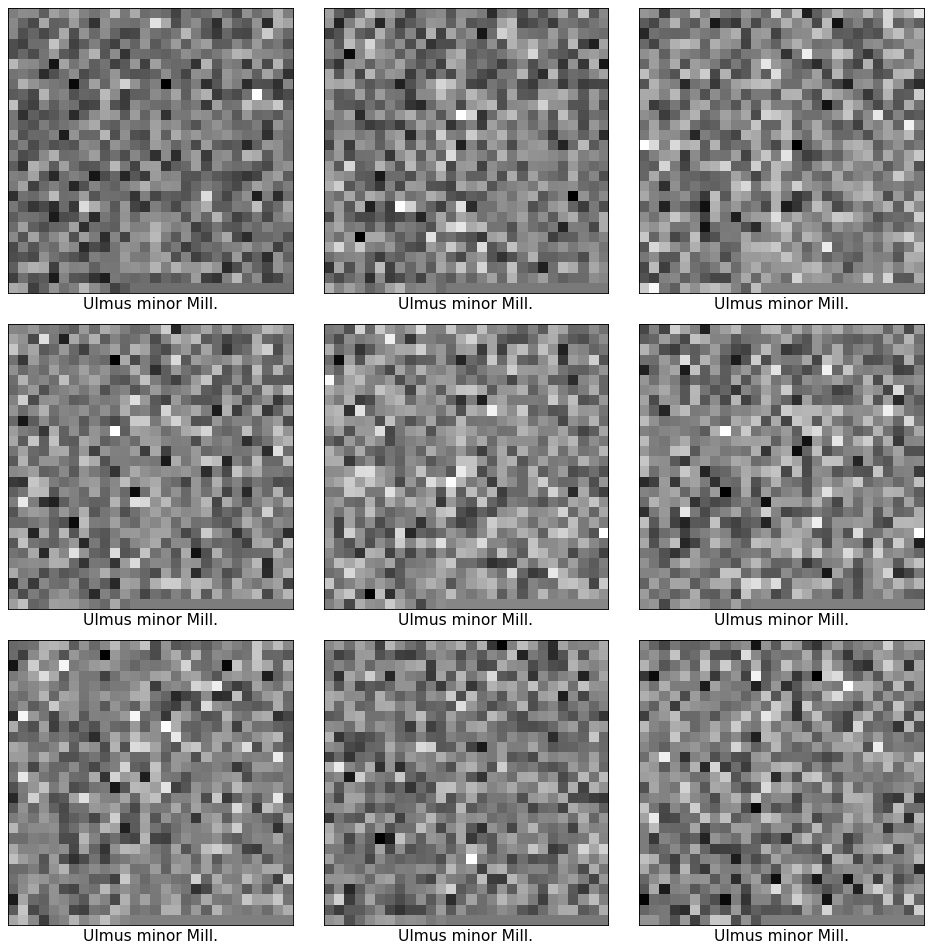

In [17]:
from plantclef.plotting import plot_images_from_embeddings

# Plot DINO image embeddings
plot_images_from_embeddings(
    filtered_df, data_col="cls_embedding", image_col="species", grid_size=(3, 3)
)

In [20]:
from plantclef.plotting import plot_images_from_binary

# Define the path to the train and test parquet files
subset_path = f"{data_path}/parquet/subset_top20_train"

# Read the parquet files into a spark DataFrame
subset_df = spark.read.parquet(subset_path)

# Select the same 9 images from filtered_df
subset_df = subset_df.filter(subset_df.image_name.isin(image_names)).cache()

# Show the data
subset_df.printSchema()
subset_df.show(n=9)

root
 |-- species_id: integer (nullable = true)
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+----------+--------------------+--------------------+--------------------+------+----------+--------+-------+--------------------+--------+------------------+-----------+---------------+-----------------+-----+--------+--------+---------+--------------------+--------------------+---------+--------------------+
|species_id|          image_name|                path|                data| organ|    obs_id| license|partner|              author|altitude|          latitude|  longitude|gbif_species_id|          species|genus|  family| dataset|publisher|          references|                 url|learn_tag|    image_backup_url|
+----------+--------------------+--------------------+--------------------+------+----------+--------+-------+--------------------+--------+------------------+-----------+---------------+-----------------+-----+--------+--------+---------+--------------------+--------------------+---------+--------------------+
|   1360607|0ea41e58db1bff720...|/PlantCLEF2024/tr...|[FF D8 

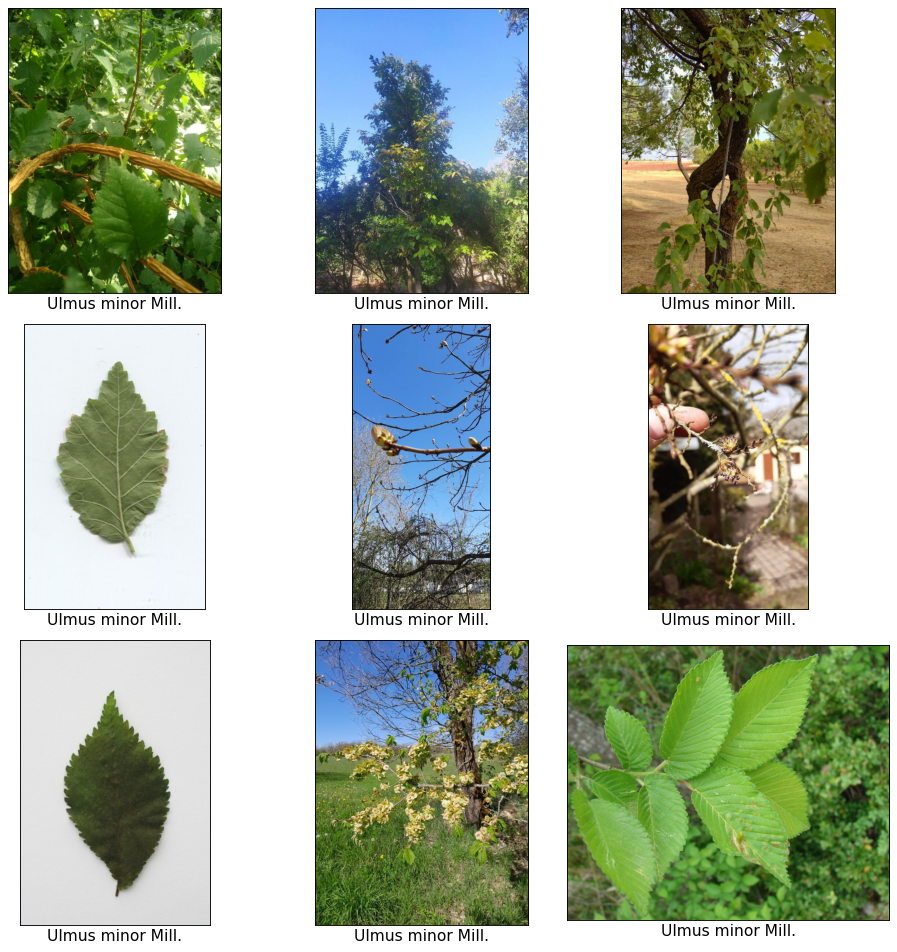

In [21]:
# Display the images in a grid with binomial names
plot_images_from_binary(
    subset_df, data_col="data", image_col="species", grid_size=(3, 3)
)

### train embeddings

In [8]:
# Read and union all Parquet files

base_dir = f"{root}/scratch/plantclef/data/embeddings"

train_emb_df = (
    spark.read.format("parquet")
    .option("pathGlobFilter", "*.parquet")
    .option("recursiveFileLookup", "true")
    .load(f"{base_dir}/train_embeddings/")
)

# Show the data
train_emb_df.printSchema()
train_emb_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+----------+--------------------+
|          image_name|species_id|       cls_embedding|
+--------------------+----------+--------------------+
|3a2c58a78ee93b471...|   1363472|[0.9020945, 0.016...|
|0a0bf86d70307e8db...|   1361957|[-0.26025677, -0....|
|7990901729be71186...|   1363472|[-0.1633016, -0.0...|
|80257a4818f5955f9...|   1392612|[-0.7547744, 0.39...|
|e13e476d0dc36ed7b...|   1360562|[0.14017674, 0.05...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [9]:
# Count the number of rows in the train embedding DataFrame
train_emb_df.count()

1408033

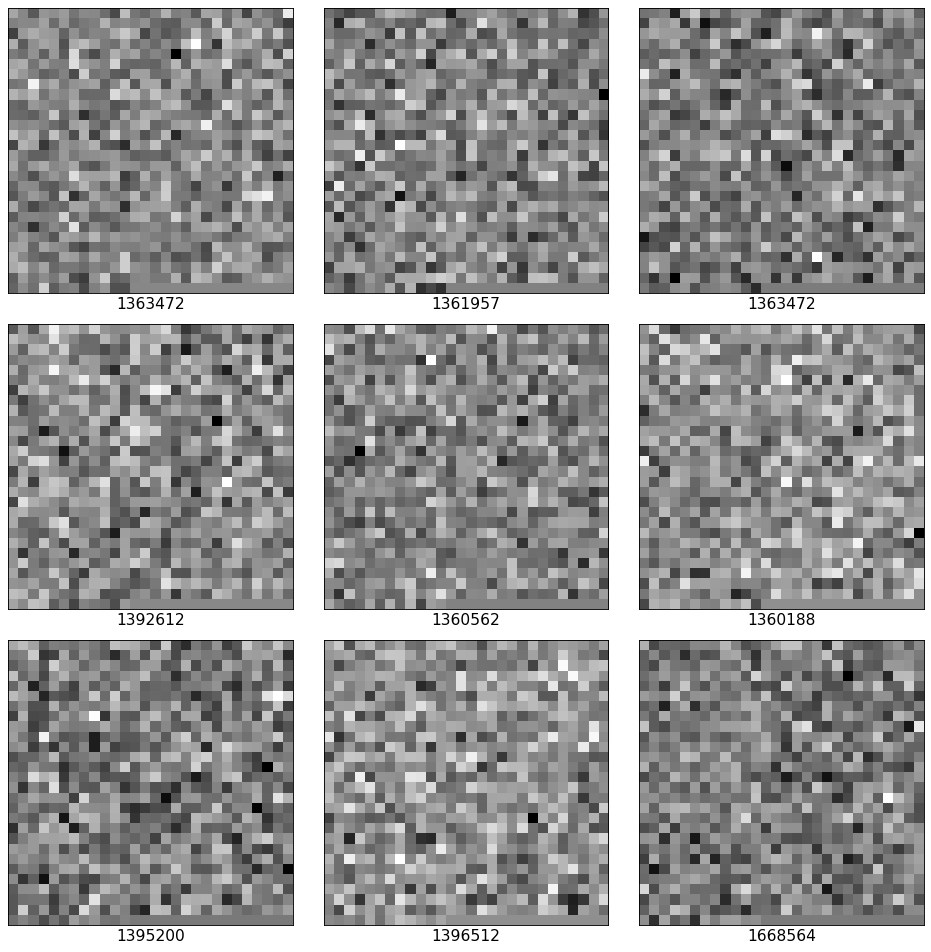

In [12]:
# Plot DINO image embeddings
plot_images_from_embeddings(
    train_emb_df, data_col="cls_embedding", image_col="species_id", grid_size=(3, 3)
)

### test embeddings

In [10]:
# # Path and dataset names
# dino_emb_train = "test_v1/dino/data"

# # Define the GCS path to the embedding files
# dino_gcs_path = f"{gcs_path}/{dino_emb_train}"

# # Read the Parquet file into a DataFrame
# test_dino_df = spark.read.parquet(dino_gcs_path)

# # Show the data
# test_dino_df.show(n=5, truncate=50)

In [11]:
# from plantclef.plotting import plot_images_from_embeddings

# # Plot test DINO image embeddings
# plot_images_from_embeddings(
#     test_dino_df, data_col="dino_embedding", image_col="image_name", grid_size=(3, 3)
# )